# INT-IDS reduction pipeline

In [115]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.stats import mad_std, sigma_clip
from scipy.signal import find_peaks

import ccdproc
from ccdproc import ImageFileCollection, CCDData

import emcee
from scipy.optimize import fmin

import warnings
from astropy.utils.exceptions import AstropyWarning


WORKDIR = '20220916'
PROCESSING = os.path.join(WORKDIR, 'processing')

try:
    os.mkdir(PROCESSING)
except OSError:
    pass

## Functions

### Plotting

In [5]:
def plot_image(data):
    """Plots a 2D image.
    
    Parameters
    ----------
    data: 2D array
        Image data.
        
    Returns
    -------
    ax: `~.axes.Axes`
        Plot axis.
    """
    m, s = np.nanmean(data), np.nanstd(data)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data, interpolation='nearest',
               cmap='gray',
               vmin=m-s, vmax=m+s,
               origin='lower')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)    
    return ax

def obs_plots(observations, obstype):
    """Plots all images of a given ``obstype``.
    
    Parameters
    ----------
    observations: `~ImageFileCollection`
        Table-like object with images information.
    obstype: str
        Type of Image. E.g. ``BIAS``, ``FLAT``.
    """    
    for filename in observations.files_filtered(include_path=True, obstype=obstype):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", AstropyWarning)
            ccd = CCDData.read(filename, hdu=1, unit=u.electron)
            plot_image(ccd.data.T)

### 2D reduction

In [11]:
def validate_method(method):
    """Checks the validity of a method for combining images.
    
    Parameters
    ----------
    method: str
        Method for conbining images: ``median`` o ``average``. 
    """
    valid_methods = ['median', 'average']
    assert method in valid_methods, f"the method used in not valid, choose from {valid_methods}"
    
    
def create_images_list(observations, obstype, subtract_overscan=True, trim_image=True, master_bias=None):
    """Creates a list of images.
    
    The images can be overscan subtracted, trimmed and bias subtracted.
    
    Parameters
    ----------
    observations: `~ImageFileCollection`
        Table-like object with images information.
    obstype: str
        Type of Image. E.g. ``BIAS``, ``FLAT``.
    subtract_overscan: bool, default ``True``.
        If ``True``, the image gets overscan subtract.
    trim_image: bool, default ``True``.
        If ``True``, the image gets trimmed.
    master_bias: `~astropy.nddata.CCDData`-like, array-like or None, optional
        Master bias image. If given, images are bias subtracted.
    
    Returns
    -------
    images_list: list
        List of images.
    """
    images_list = []
    
    for filename in observations.files_filtered(include_path=True, obstype=obstype):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", AstropyWarning)
            ccd = CCDData.read(filename, hdu=1, unit=u.adu)
            
        ## Set up the reduction based on Gain and Readout.
        ccd = ccdproc.create_deviation(
            ccd, 
            gain = ccd.header['GAIN']*u.electron / u.adu,
            readnoise = ccd.header['READNOIS'] * u.electron
        )
        ## Actually correct for gain.
        ccd = ccdproc.gain_correct(ccd, ccd.header['GAIN'] * u.electron / u.adu)

        if subtract_overscan:
            #ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
            ccd = ccdproc.subtract_overscan(ccd, median = True, overscan_axis = 0, overscan=ccd[4110:4190, :])
        if trim_image:
            #ccd = ccdproc.trim_image(ccd, ccd.header['TRIMSEC'])
            ccd = ccdproc.trim_image(ccd[:4096, :])
        if master_bias is not None:
            ccd = ccdproc.subtract_bias(ccd, master_bias) 
        images_list.append(ccd)
        
    return images_list


def inv_median(array):
    """Inverse median function.
    """
    return 1 / np.nanmedian(array)
    
    
def combine_images(images_list, method='average', scale=None):
    """Combines a list of images.
    
    Parameters
    ----------
    images_list: list
        List of images.
    method: str, default ``average``
        Method for conbining images: ``median`` o ``average``.
    scale: function or `numpy.ndarray`-like or None, optional
    
    Returns
    -------
    master_image: `~astropy.nddata.CCDData`
        Combined image.
    """
    validate_method(method)
    if method=='median':
        master_image = ccdproc.combine(images_list, method=method, scale=scale)
    
    elif method=='average':
        master_image = ccdproc.combine(images_list, method=method, scale=scale,
                                       sigma_clip=True, sigma_clip_low_thresh=5, 
                                       sigma_clip_high_thresh=5, sigma_clip_func=np.ma.median, 
                                       signma_clip_dev_func=mad_std, mem_limit=350e6)   
        
    return master_image
        

def create_master_bias(observations, subtract_overscan=True, trim_image=True, 
                       method='average', save_output=True):
    """Creates a master bias image.
        
    Parameters
    ----------
    observations: `~ImageFileCollection`
        Table-like object with images information.
    subtract_overscan: bool, default ``True``.
        If ``True``, the image gets overscan subtract.
    trim_image: bool, default ``True``.
        If ``True``, the image gets trimmed.
    method: str, default ``average``
        Method for conbining images: ``median`` o ``average``.
    save_output: bool, default ``True``
        If ``True``, the master flat image is saved in the processing directory.
    
    Returns
    -------
    master_bias: `~astropy.nddata.CCDData`
        Master bias image.
    """
    obstype = 'BIAS'
    bias_list = create_images_list(observations, obstype, subtract_overscan, trim_image)
    master_bias = combine_images(bias_list, method)
    print(f'{len(bias_list)} images combined for the master BIAS')
    
    if save_output:
        outfile = os.path.join(PROCESSING, 'master_bias.fits')
        master_bias.write(outfile, overwrite=True)
    
    return master_bias
    
    
def create_master_flat(observations, master_bias=None, subtract_overscan=False, 
                       trim_image=True, method='average', scale_flats=True, save_output=True): 
    """Creates a master flat image.
    
    Parameters
    ----------
    observations: `~ImageFileCollection`
        Table-like object with images information.
    master_bias: `~astropy.nddata.CCDData`-like, array-like or None, optional
        Master bias image. If given, images are bias subtracted.
    subtract_overscan: bool, default ``True``.
        If ``True``, the image gets overscan subtract.
    trim_image: bool, default ``True``.
        If ``True``, the image gets trimmed.
    method: str, default ``average``
        Method for conbining images: ``median`` o ``average``.
    scale_flats: bool, default ``True``
        If ``True``, the flats are scaled by the inverse median before being combined.
    save_output: bool, default ``True``
        If ``True``, the master flat image is saved in the processing directory.
    
    Returns
    -------
    master_flat: `~astropy.nddata.CCDData`
        Master flat image.
    """
    obstype = 'FLAT'
    if scale_flats:
        scale = inv_median
    else:
        scale = None
        
    subtract_overscan = False
    flat_list = create_images_list(observations, obstype, subtract_overscan, trim_image, master_bias)
    master_flat = combine_images(flat_list, method, scale=scale)
    print(f'{len(flat_list)} images combined for the master FLAT')
    
    if save_output:
        outfile = os.path.join(PROCESSING, 'master_flat.fits')
        master_flat.write(outfile, overwrite=True)
    
    return master_flat
        
        
def reduce_images(observations, master_bias=None, master_flat=None, subtract_overscan=False, 
                  trim_image=True, method='average', save_output=True):
    """Reduces science images.
    
    If more than one image of the same target is given, these are combined.
    
    Parameters
    ----------
    observations: `~ImageFileCollection`
        Table-like object with images information.
    master_bias: `~astropy.nddata.CCDData`-like, array-like or None, optional
        Master bias image. If given, images are bias subtracted.
    subtract_overscan: bool, default ``True``.
        If ``True``, the image gets overscan subtract.
    trim_image: bool, default ``True``.
        If ``True``, the image gets trimmed.
    method: str, default ``average``
        Method for conbining images: ``median`` o ``average``.
    save_output: bool, default ``True``
        If ``True``, the science images are saved in the processing directory.
        
    Returns
    -------
    red_images: list
        List of reduced images.
    """
    obs_df = observations.summary.to_pandas()
    object_names = obs_df[obs_df.obstype=='TARGET'].object.unique()

    red_images = []
    for object_name in object_names:
        if 'focus' in object_name:
            continue  # skips this
        print("Reducing:", object_name)
        target_list = []
        
        for filename in observations.files_filtered(include_path=True, object=object_name):
            hdu = fits.open(filename)
            print(filename)
            header = hdu[0].header+hdu[1].header
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", AstropyWarning)
                ccd = CCDData(hdu[1].data, header=header, unit=u.adu)
                
            ccd = ccdproc.create_deviation(
                ccd,
                gain = ccd.header['GAIN'] * u.electron / u.adu,
                readnoise = ccd.header['READNOIS'] * u.electron
            )
            ccd = ccdproc.gain_correct(ccd, ccd.header['GAIN'] * u.electron / u.adu)

            try:
                ccd = ccdproc.cosmicray_lacosmic(ccd, niter=10)
                if subtract_overscan:
                    ccd = ccdproc.subtract_overscan(ccd, median=True, overscan_axis=0, overscan=ccd[4110:4190,:])
                if trim_image:
                    ccd = ccdproc.trim_image(ccd[:4096,:])
                if master_bias is not None:
                    ccd = ccdproc.subtract_bias(ccd, master_bias)
                if master_flat is not None:
                    ccd = ccdproc.flat_correct(ccd, master_flat, min_value = 0.1)
        
                # Rotate Frame
                ccd.data = ccd.data.T
                ccd.mask = ccd.mask.T
                target_list.append(ccd)
            except Exception as error:
                print(error)

        if len(target_list)>0:
            validate_method(method)
            combiner = ccdproc.Combiner(target_list)
            if method=='average':
                red_target = combiner.average_combine()
            elif method=='median':
                red_target = combiner.median_combine()
            red_images.append(red_target)
            
            if save_output:
                outfile = os.path.join(PROCESSING, f'{object_name}.fits')
                red_target.write(outfile, overwrite=True)
        
    return red_images

### 1D reduction: trace extraction

In [256]:
def quick_trace(data, center=None, width=50, gap=20, sky_width=40 , plot_trace=False):
    """Extracts a "raw" spectrum in a quick way.
    
    The trace is background subtracted.
    
    Parameters
    ----------
    data: `~astropy.nddata.CCDData`-like, array-like
        Image data.
    center: float or None, optional
        Center of the trace. If not give, one is obtained with ``find_peaks``,
        using the peak with the largest amplitud.
    width: float, default ``50``
        Width of the trace in pixels.
    gap: float, default ``20``
        Separation between the trace and sky in pixels.
    sky_width: float, default ``40``
        Width of the sky in pixels. Used for background subtraction.
    plot_trace: bool, default ``False``
        If ``True``, the image is plotted with the trace. The raw spectrum is also plotted.
    
    Returns
    -------
    raw_spectrum: array
        Raw spectrum of the image.
    """
    if center is None:
        ny, nx = data.shape
        center0 = ny//2
        peaks = find_peaks(data[:,nx//2].data,
                            height=np.nanmedian(data[:,nx//2]), 
                            width=10)[0]
        peak_id = np.argmax(data[:,nx//2][peaks])
        center = peaks[peak_id]
    
    imin = int(center-width//2)
    imax = int(center+width//2)
    raw_spectrum = np.nansum(data[imin:imax], axis=0)
    
    # sky on one side
    imin_sky1 = int(center-(width//2+gap+sky_width))
    imax_sky1 = int(center-(width//2+gap))
    sky1 = np.nansum(data[imin_sky1:imax_sky1], axis=0)
    
    # sky on the other side
    imin_sky2 = int(center+(width//2+gap))
    imax_sky2 = int(center+(width//2+gap+sky_width))
    sky2 = np.nansum(data[imin_sky2:imax_sky2], axis=0)
    
    # sky subtraction
    sky = np.nanmean(sky1 + sky2, axis=0)
    raw_spectrum = raw_spectrum - sky
    
    # invert axis and convert masked array into array
    raw_spectrum = raw_spectrum[::-1].data
    
    if plot_trace:
        for i in range(2):
            if i==1:
                data = data[:, 1900:2100]
                
            ax = plot_image(data)
            ax.axhline(imin, c='r', lw=2, label='aperture')
            ax.axhline(imax, c='r', lw=2)
            ax.axhspan(imin_sky1, imax_sky1, color='g', alpha=0.4, label='sky')
            ax.axhspan(imin_sky2, imax_sky2, color='g', alpha=0.4)
        ax.legend(fontsize=16)
        plt.show()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(raw_spectrum)
        ax.set_xlabel('Column (pixels)', fontsize=16)
        ax.set_ylabel('Raw Flux', fontsize=16)
        plt.show()
    
    return raw_spectrum

In [257]:
def get_profile_model(params, ys):
    """Gaussian function with offset for fitting.
    """
    amplitude, center, sigma, yoffset = params
    
    profile = np.exp(-(ys - center)**2 / 2 / sigma**2) 
    profile /= profile.max()
    profile *= amplitude
    profile += yoffset

    return profile

def get_profile_chisq(params, ys, profile):
    """Reduced chi-squared for fitting.
    """
    model = get_profile_model(params, ys)
    
    return np.sum( (profile - model)**2 / (profile.size - len(params)))

def calc_trace(data, center=None, amp=None, hwidth=50, t_order=3, sky_width=40, plot_diag=False, plot_trace=False):
    """Extracts a "raw" spectrum in an optimised way.
    
    The trace is background subtracted. Sigma clipping is used for removing "untrusted" fits.
    The sky width is fixed.
    
    Parameters
    ----------
    data: `~astropy.nddata.CCDData`-like, array-like
        Image data.
    center: float or None, optional
        Initial guess of the trace center. If not give, one is obtained with ``find_peaks``,
        using the peak with the largest amplitud.
    amp: float or None, optional
        Initial guess of the trace amplitude. If not give, one is obtained with ``find_peaks``.
    hwidth: float, default ``50``
        Number of columns to used for each step in the column axis. These are "collapsed" together.
    t_order: float, default ``3``
        Order of the polynomial used for fitting the trace.
    sky_width: float, default ``40``
        Width of the sky in pixels. Used for background subtraction.
    plot_diag: bool, default ``False``
        If ``True``, a set of diagnostic plots are shown for each step and the final solution as well.
    plot_trace: bool, default ``False``
        If ``True``, the image is plotted with the trace. The raw spectrum is also plotted.
    
    Returns
    -------
    raw_spectrum: array
        Raw spectrum of the image.
    """
    
    ny, nx = data.shape
    cy, cx = ny//2, nx//2
    xs = np.arange(nx)
    ys = np.arange(ny)
    yvals, xvals = np.indices(data.shape)
    
    cols = np.arange(hwidth, nx + 1, 2 * hwidth)
    ycenter = np.zeros(len(cols))
    ywidth = np.zeros(len(cols))
    init_sky = np.zeros(len(cols))
    
    for icol, col in enumerate(cols):
        stamp = data[:, col - hwidth : col + hwidth]
        profile = np.nanmean(stamp, axis=1)

        if center is None or amp is None:
            peaks = find_peaks(profile, height=np.nanmedian(profile), width=10)[0]
            amp = np.max(profile[peaks])
            peak_id = np.argmax(profile[peaks])
            center = peaks[peak_id]
        guess = (amp, center, 5, np.nanmedian(profile))
        
        params = fmin(get_profile_chisq, guess, args=(ys, profile), disp=False)
        if params[2] < 20:
            ycenter[icol] = params[1]
            ywidth[icol] = 4*params[2]  # aperture width of 4 sigmas
            init_sky[icol] = 5*params[2]  # sky starts at 5 sigmas
            model = get_profile_model(params, ys)

            if plot_diag:
                fig, ax = plt.subplots(figsize=(12, 6))
                ax.plot(ys, profile, label='data')
                ax.plot(ys, model, label='model')
                ax.axvline(ycenter[icol]+ywidth[icol], c='r', ls='dotted', label='aperture')
                ax.axvline(ycenter[icol]-ywidth[icol], c='r', ls='dotted')
                ax.axvspan(ycenter[icol]+init_sky[icol], ycenter[icol]+init_sky[icol]+20, 
                           alpha=0.3, color='red', label='sky')
                ax.axvspan(ycenter[icol]-init_sky[icol], ycenter[icol]-init_sky[icol]-20, 
                           alpha=0.3, color='red')
                ax.set_xlabel('Column Number (pixels)', fontsize=16)
                ax.set_ylabel('Median Column Counts', fontsize=16)
                ax.legend()
                plt.grid();
                plt.show()
        else:
            ycenter[icol] = np.inf
            ywidth[icol] = np.inf
            init_sky[icol] = np.inf
    
    # remove bad fits
    mask = np.isfinite(ycenter)
    ycenter = ycenter[mask]
    ywidth = ywidth[mask]
    init_sky = init_sky[mask]
    cols = cols[mask]
    
    # remove untrusted fits with sigma clipping
    mask = ~sigma_clip(ycenter, maxiters=10).mask
    ycenter = ycenter[mask]
    ywidth = ywidth[mask]
    init_sky = init_sky[mask]
    cols = cols[mask]

    trace_coef = np.polyfit(cols, ycenter, t_order)
    trace = np.polyval(trace_coef, xs)
    
    # trace aperture
    trace_top = trace+ywidth.mean()
    trace_bottom = trace-ywidth.mean()
    
    # sky
    sky_top = trace+init_sky.mean()
    sky_bottom = trace-init_sky.mean()

    # diagnostic plots
    if plot_diag:
        fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
        ax[0].plot(cols, ycenter, 'ro', label='data')
        ax[0].plot(xs, trace, 'r', label='spline')
        ax[0].plot(xs, trace_top, 'r', ls='--', label='aperture')
        ax[0].plot(xs, trace_bottom, 'r', ls='--')
        ax[0].set_title('Trace', fontsize=16)
        ax[0].axes.set_ylabel('y-coordinate', fontsize=16)
        ax[0].legend()
        ax[0].grid()

        trace_col = np.polyval(trace_coef, cols)
        ax[1].plot(cols, ycenter - trace_col, 'ro')
        ax[1].axhline(0.0, c='k')
        ax[1].axes.set_ylabel('Fit Residual (pixels)', fontsize=16)
        ax[1].set_xlabel('Column Number', fontsize=16)
        ax[1].grid()
        plt.show()
    
    if plot_trace:
        plot_data = np.copy(data)
        for i in range(2):
            if i==1:
                # zoom in
                plot_data = plot_data[:, 1900:2100]
                
            ax = plot_image(plot_data)
            ax.plot(xs, trace_top, c='r', lw=2, label='aperture')
            ax.plot(xs, trace_bottom, c='r')
            ax.fill_between(xs, sky_top, sky_top+sky_width, color='g', alpha=0.4, label='sky')
            ax.fill_between(xs, sky_bottom, sky_bottom-sky_width, color='g', alpha=0.4)
            ymax, xmax = plot_data.shape
            ax.set_xlim(0, xmax)
            ax.set_ylim(0, ymax)
            
        ax.legend(fontsize=16)
        plt.show() 
        
    raw_spectrum = np.zeros_like(trace)
    try:
        data = data.data # avoid using masked array
    except:
        pass
    
    for i in xs:
        # sky with a fixed width
        imin = int(sky_bottom[i]-sky_width)
        imax = int(sky_bottom[i])
        sky1 = np.nansum(data[imin:imax,i])
        
        imin = int(sky_top[i])
        imax = int(sky_top[i]+sky_width)
        sky2 = np.nansum(data[imin:imax,i])
        
        # take the average sky of both sides
        sky = np.mean(sky1 + sky2) 
        
        imin = int(trace_bottom[i])
        imax = int(trace_top[i])
        # with background subtraction + sigma clipping
        slice_data = data[imin:imax,i]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", AstropyWarning)
            mask = ~sigma_clip(slice_data, maxiters=10).mask
            raw_spectrum[i] = np.nansum(slice_data[mask]) - sky 
    
    # the axis is inverted
    raw_spectrum = raw_spectrum[::-1]
    
    if plot_trace:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(raw_spectrum)
        ax.set_xlabel('Column (pixels)', fontsize=16)
        ax.set_ylabel('Raw Flux', fontsize=16)
        plt.show()
    
    return raw_spectrum

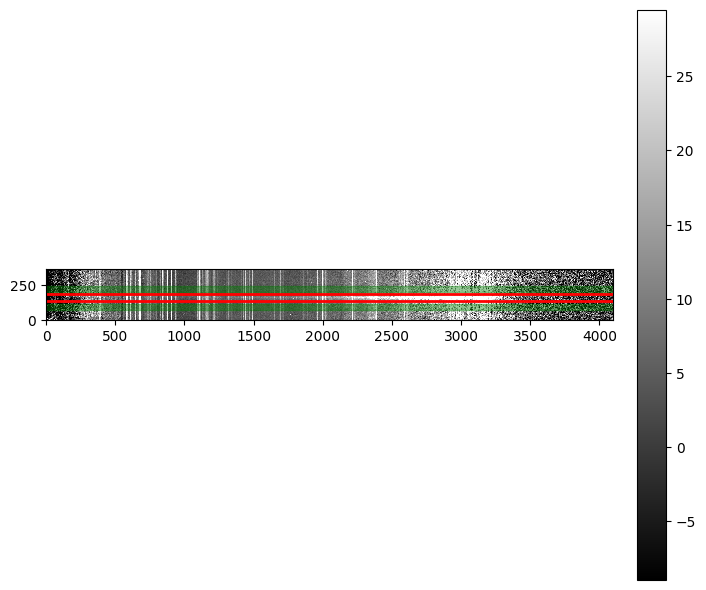

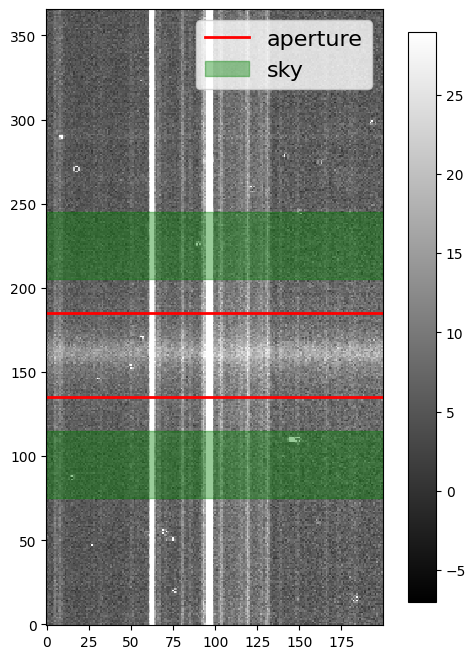

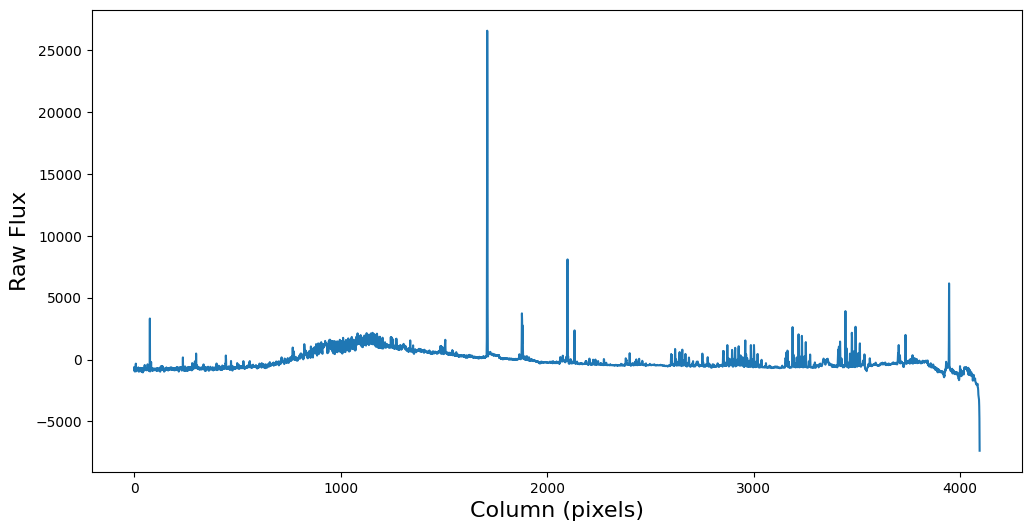

In [258]:
raw_spectrum = quick_trace(red_images[1], plot_trace=True)

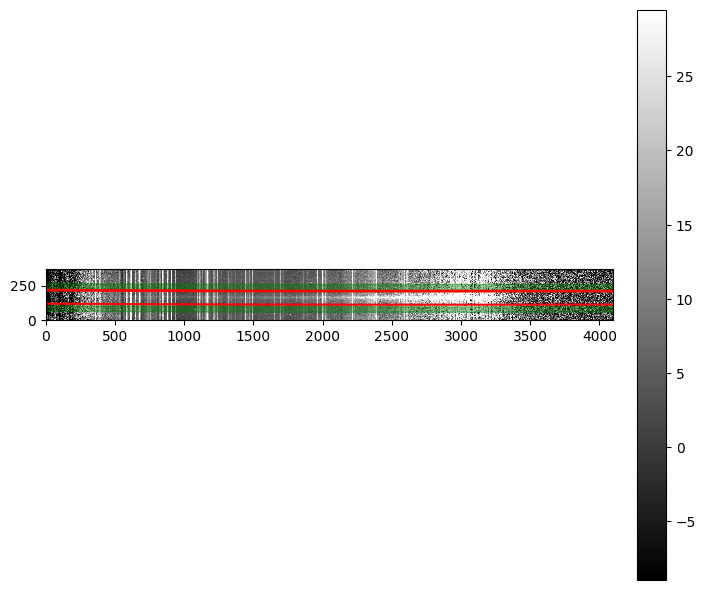

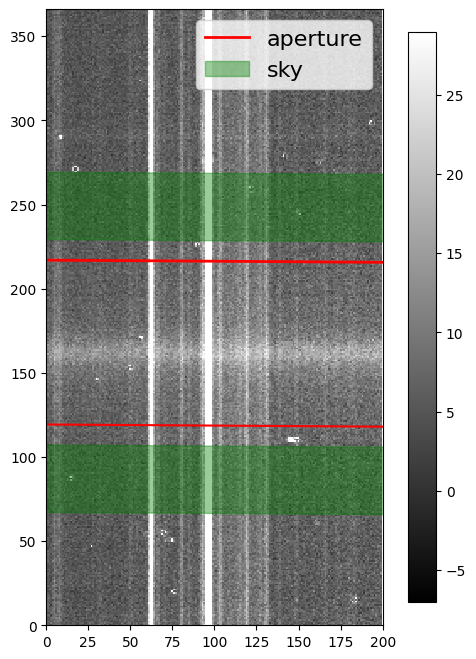

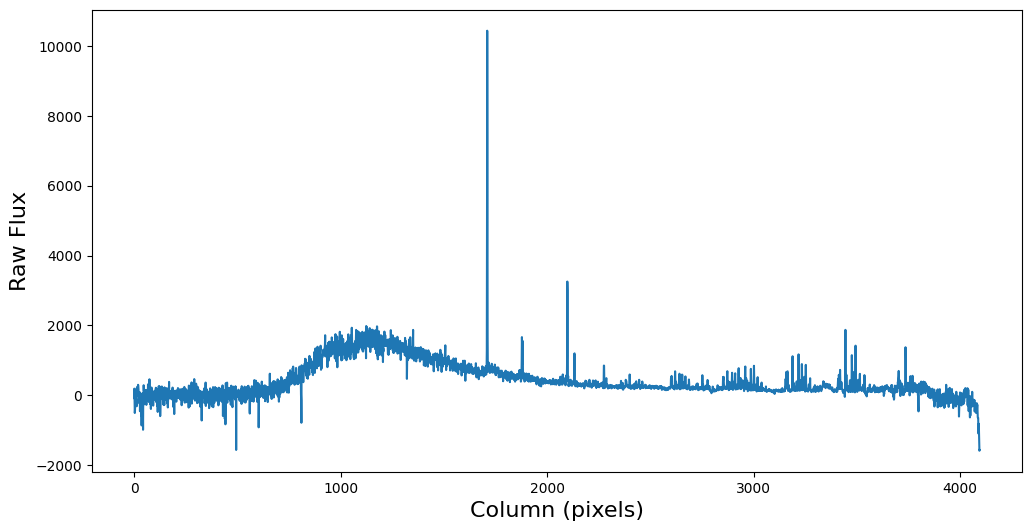

In [259]:
raw_spectrum = calc_trace(red_images[1], center=165, amp=20, t_order=3, plot_diag=False, plot_trace=True)

## Reduction

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    observations = ImageFileCollection(WORKDIR)

subtract_overscan = True    
trim_image= True
method = 'average'

master_bias = create_master_bias(observations, subtract_overscan, trim_image, method)
master_flat = create_master_flat(observations, master_bias, subtract_overscan, trim_image, method)

INFO:astropy:splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


42 images combined for the master BIAS


INFO:astropy:splitting each image into 6 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 6 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
30 images combined for the master FLAT


In [26]:
red_images = reduce_images(observations, master_bias, master_flat, subtract_overscan, trim_image, method)

Reducing: 2022ESA
20220916/r1632356.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: SN2012DN-CENTER
20220916/r1632358.fit


20220916/r1632360.fit


20220916/r1632362.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 92-342
20220916/r1632365.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 2018EBT-CENTER
20220916/r1632367.fit


20220916/r1632370.fit


20220916/r1632372.fit


20220916/r1632374.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 114-750
20220916/r1632376.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 2021AESS
20220916/r1632378.fit


20220916/r1632380.fit


20220916/r1632381.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reducing: 98-185
20220916/r1632384.fit


/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/tomas/anaconda3/envs/reduction/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<AxesSubplot: >

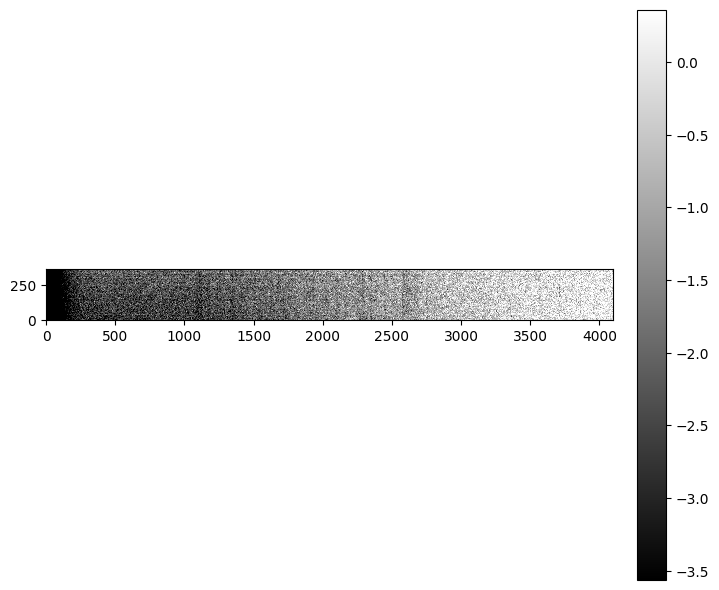

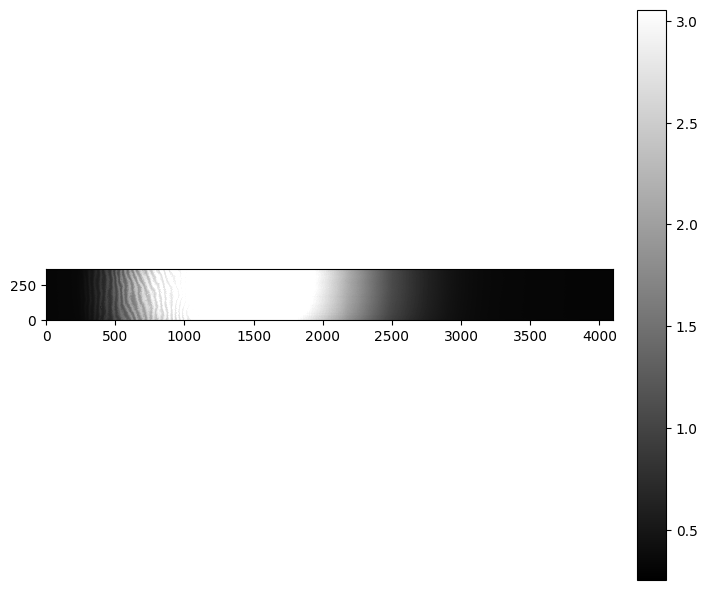

In [ ]:
plot_image(master_bias.data.T)
plot_image(master_flat.data.T)